In [5]:
from importlib.metadata import version

pkgs = [ "matplotlib", "numpy", "tiktoken", "torch"]

for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.10.0
numpy version: 2.2.2
tiktoken version: 0.8.0
torch version: 2.5.1


In [31]:
import torch 
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader



In [20]:

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [6]:
#DataSet Class  for martin-gpt

class GPT_Dataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids =  []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
            

In [10]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                         shuffle=True, drop_last=True, num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = GPT_Dataset(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                            drop_last=drop_last, num_workers=num_workers)
    
    return dataloader

In [28]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        
        b, num_tokens, d_in = x.shape
        
        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)
        
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        
        
        attn_scores = queries @ keys.transpose(2,3)
        
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        
        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec
        

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = ( x - mean ) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

In [15]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            GELU(), 
            nn.Linear(emb_dim * 4, emb_dim)
        )

    def forward(self, x):
        return self.layers(x)
        
        

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        
        self.att = MultiHeadAttention(d_in=cfg["emb_dim"],
                                      d_out=cfg["emb_dim"],
                                      context_length=cfg["context_length"],
                                      dropout=cfg["drop_rate"],
                                      num_heads=cfg["n_heads"],
                                      qkv_bias=cfg["qkv_bias"]) 
        self.ff = FeedForward(cfg["emb_dim"])
        self.norm_1 = LayerNorm(cfg["emb_dim"])
        self.norm_2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
        
    def forward(self, x):
        
        shortcut = x
        
        x = self.norm_1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x
        

In [22]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

In [19]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]
        
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        idx = torch.cat((idx, idx_next), dim=-1)
        
        idx = torch.cat((idx, idx_next), dim=-1)
        
    return idx

    
    if __name__ == "__main__":
        
        GPT_CONFIG = {
            "vocab_size": 50257,
            "context_length": 1024,
            "emb_dim": 768,
            "n_heads": 12,
            "n_layers": 12,
            "drop_rate": 0.1,
            "qkv_bias": False,
        }

        torch.manual_seed(123)
        model = GPTModel(GPT_CONFIG)
        model.eval() 
        
        start_context = "Hello, I am" 
        
        tokenizer = tiktoken.get_encoding("gpt2")
        encoded = tokenizer.encode(start_context)
        encoded_tensor = torch.tensor(encoded).unsqueeze(0)
        
        print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
        print("\nInput text:", start_context)
        print("Encoded input text:", encoded)
        print("encoded_tensor.shape:", encoded_tensor.shape)

        out = generate_text_simple(
            model=model,
            idx=encoded_tensor,
            max_new_tokens=10,
            context_size=GPT_CONFIG_124M["context_length"]
        )
        decoded_text = tokenizer.decode(out.squeeze(0).tolist())

        print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
        print("\nOutput:", out)
        print("Output length:", len(out[0]))
        print("Output text:", decoded_text)

In [2]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [32]:

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
# token_ids = text_to_token_ids(start_context, tokenizer)
# token_ids = torch.tensor(token_ids).to(device)


# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids(start_context, tokenizer),
#     max_new_tokens=10,
#     context_size=GPT_CONFIG_124M["context_length"]
# )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you renting rentinguffuffmondmondrunnerrunnerWrWr � � lists lists Parish Parish Cooperative Cooperative


In [35]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [37]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


In [34]:
train_ratio = 0.90

split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)


val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [38]:
# SANITY CHECK


if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [39]:
print("Train loader")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader")
for x, y in val_loader:
    print(x.shape, y.shape)
    

Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten()) 
    return loss 

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
    

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Train loss: {train_loss}")
print(f"Validation loss: {val_loss}")


Train loss: 10.98738521999783
Validation loss: 10.980905532836914


In [43]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    #main training loop 
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
        
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(f"Epoch: {epoch+1} | "
                      f"Global Step: {global_step:06d} | "
                      f"Tokens Seen: {tokens_seen:09d} | "
                      f"Train Loss: {train_loss:.3f} | "
                      f"Validation Loss: {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

                
                

In [ ]:
"""  Training the model """
import time 
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5, start_context="Every Effort moves you", tokenizer=tokenizer
)
 
end_time = time.time()
print(f"Training took {(end_time - start_time)/60} minutes")


Epoch: 1 | Global Step: 000000 | Tokens Seen: 000000512 | Train Loss: 9.784 | Validation Loss: 9.928
Epoch: 1 | Global Step: 000005 | Tokens Seen: 000003072 | Train Loss: 7.986 | Validation Loss: 8.336
Every Effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,..      
Training took 1.0449422001838684 seconds


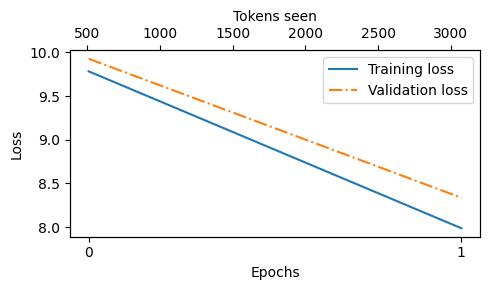

: 

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)